## ARIMA 모형

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 한글 및 부호 깨지지 않게 하는 코드
plt.rc('font', family='Malgun Gothic')
plt.rc("axes", unicode_minus = False)

In [3]:
samsung = yf.download('005930.KS',start='2018-01-01',end='2021-12-31',adjusted=True,progress=False)
samsung_week = samsung.resample('W').last().rename(columns={'Adj Close': 'adj_close'}).adj_close # 주별 주기 샘플링
samsung_week.head(10)

Date
2018-01-07    46049.687500
2018-01-14    42586.238281
2018-01-21    43575.800781
2018-01-28    44865.757812
2018-02-04    42144.480469
2018-02-11    39493.878906
2018-02-18    43293.074219
2018-02-25    41720.378906
2018-03-04    40660.148438
2018-03-11    43946.875000
Freq: W-SUN, Name: adj_close, dtype: float64

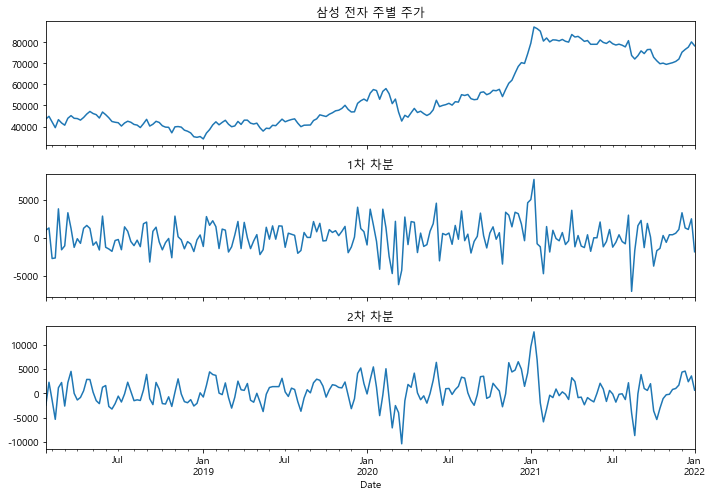

In [4]:
samsung_diff1 = samsung_week.diff(1).dropna()
samsung_diff2 = samsung_week.diff(2).dropna()

fig, ax = plt.subplots(3, sharex=True,figsize=(10,7))
samsung_week.plot(title = "삼성 전자 주별 주가", ax=ax[0])
samsung_diff1.plot(ax=ax[1], title='1차 차분')
samsung_diff2.plot(ax=ax[2], title='2차 차분')
plt.tight_layout()
plt.show()

- 원래의 삼성 전자의 주별 종가 데이터와 1차 차분된 데이터를 가지고 정상성 검정을 실시한다.

In [5]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [6]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value','# Lags', '# Observation']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [7]:
def kpss_test(x, h0_type): 
    indices = ['Test Statistic', 'p-value', '# Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [8]:
def stationery_test(x, n_lags=40, alpha=0.05, h0_type='c'):

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],kpss_results['p-value']))

    fig, ax = plt.subplots(2,1, figsize=(10, 7))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)
    
    return plt.show()

ADF test statistic: -0.36 (p-val: 0.92)
KPSS test statistic: 1.14 (p-val: 0.01)


C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


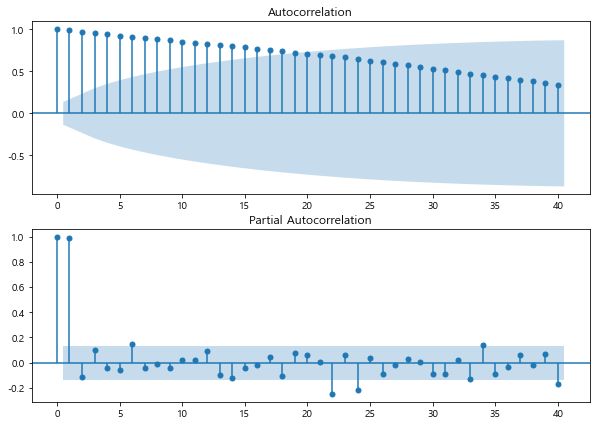

In [9]:
stationery_test(samsung_week)

원 데이터를 가지고 정상성 검정을 실시해보면, 데이터가 정상성을 만족하지 못함을 두 개의 test와 ACF 그래프를 통해 알 수 있다.

ADF test statistic: -14.01 (p-val: 0.00)
KPSS test statistic: 0.16 (p-val: 0.10)


C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


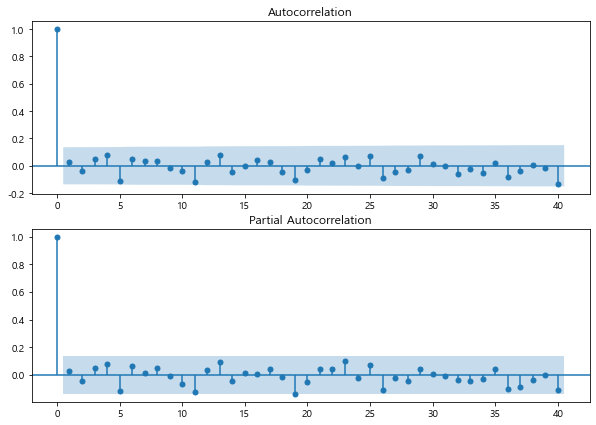

In [10]:
# 1차 차분 데이터 정상성 검정
stationery_test(samsung_diff1)

1차 차분된 데이터를 가지고 정상성 검정을 실시한 결과를 볼 때, 데이터가 정상성을 만족함을 알 수 있다. <br>
ACF와 PACF를 볼 때, ARIMA(0,1,0) 모형을 사용하여 예측하는 것이 좋아보인다.

In [11]:
arima = ARIMA(samsung_week,order=(0,1,0)).fit(disp=0)
arima.summary()

C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  208
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1874.384
Method:                           css   S.D. of innovations           1983.312
Date:                Fri, 15 Apr 2022   AIC                           3752.768
Time:                        18:30:08   BIC                           3759.443
Sample:                    01-14-2018   HQIC                          3755.467
                         - 01-02-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        155.0496    137.518      1.127      0.260    -114.481     424.580
==============================================================================
"""

- 그 후 잔차에 기반해 모델의 적합화를 진단한다.

In [12]:
def arima_diagnostics(resids, n_lags):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r) #nanmean: na를 무시하고 산술평균 계산
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # 잔차 lineplot 그리기
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')
    
    # 표준 정규분포 pdf 만들기
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    # 잔차 히스토그램
    sns.distplot(resids_nonmissing, hist=True, kde=True, norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q 플롯
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF 그래프
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

C:\Users\uos\miniconda3\envs\dong\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


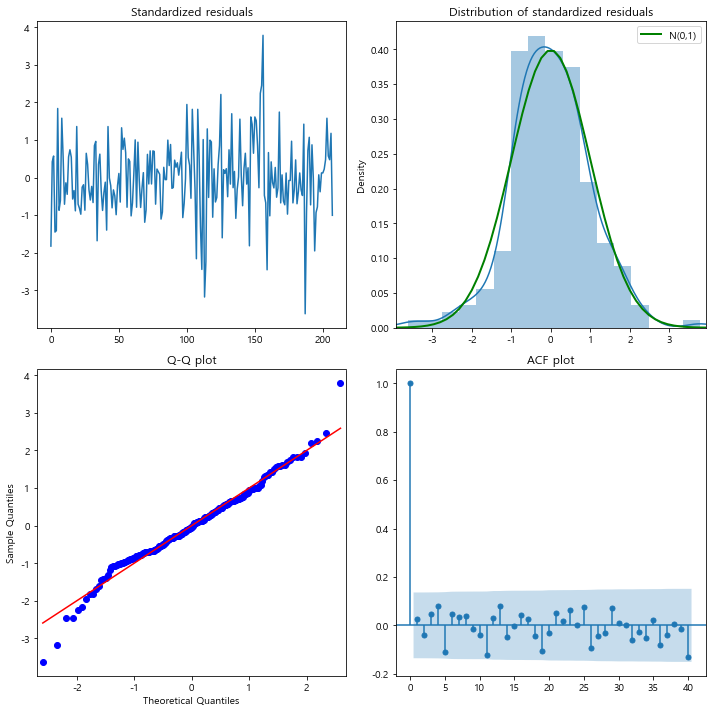

In [13]:
arima_diagnostics(arima.resid,40)
plt.tight_layout()
plt.show()

잔차의 분포를 보았을 때 정규분포에 가까워 보이며, ACF 그래프에서도 잔차의 상관성이 전혀 보이지 않으므로 ARIMA 모형이잘 적합된 것으로 보인다.

- Ljung-Box test를 통해 잔차가 상관관계가 없다는 것을 검정한다.

C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
C:\Users\uos\miniconda3\envs\dong\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


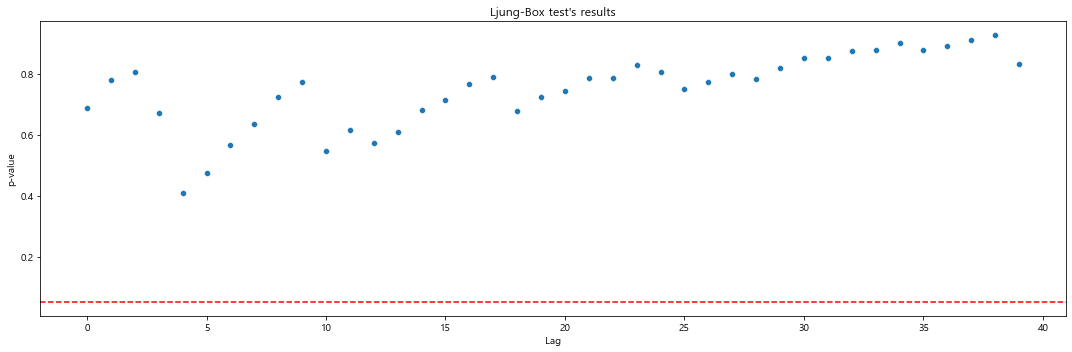

In [14]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[15, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), y=ljung_box_results[1], ax=ax)
ax.axhline(0.05, ls='--', c='r') #유의수준
ax.set(title="Ljung-Box test's results",xlabel='Lag',ylabel='p-value')

plt.tight_layout()
plt.show()

위의 그림은 lag 마다 Ljung-Box test의 p-value를 도식화한 것이다. 어떤 lag에서도 '자기 상관이 없다.'는 귀무가설을 기각할 증거를 가지지 못하므로, 잔차에 상관관계가 없다는 것을 알 수 있다.

### AUTO-ARIMA

In [15]:
import pmdarima as pm

In [16]:
model = pm.auto_arima(samsung_week,error_action='ignore',suppress_warnings=True,seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1875.019
Date:                Fri, 15 Apr 2022   AIC                           3752.038
Time:                        18:30:09   BIC                           3755.376
Sample:                             0   HQIC                          3753.388
                                - 209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.939e+06   2.96e+05     13.321      0.000    3.36e+06    4.52e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                17.41
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AUTO-ARIMA 결과는 seasonal 변수가 추가된 SARIMA(0,1,0) 모형이 가장 좋은 예측 모형이 될 것이라고 나왔다.

In [17]:
auto_arima = pm.auto_arima(samsung_week,error_action='ignore',suppress_warnings=True,seasonal=True,stepwise=False,approximation=False,n_jobs=-1)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1874.384
Date:                Fri, 15 Apr 2022   AIC                           3752.768
Time:                        18:30:14   BIC                           3759.443
Sample:                             0   HQIC                          3755.467
                                - 209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    155.0496    137.575      1.127      0.260    -114.592     424.691
sigma2      3.934e+06   2.95e+05     13.317      0.000    3.35e+06    4.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                17.41
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

단계적 알고리즘을 제외하더라도 위의 결과와 같은 결과가 나온 것을 ㅇ라 수 있다.

### Prediction

- 2022년 1~3월의 주가 데이터를 불러와 ARIMA 예측값과 비교해본다.

In [18]:
sam_test = yf.download('005930.KS',start='2022-01-01',end='2022-03-31',adjusted=True,progress=False)

In [19]:
sam_test = sam_test.resample('W').last().rename(columns={'Adj Close': 'adj_close'}).adj_close 

In [20]:
n_forecasts = len(sam_test)
arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower', 'ci_upper'])] #95% 신뢰구간
arima_pred = pd.concat(arima_pred, axis=1).set_index(sam_test.index)

In [21]:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, return_conf_int=True, alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], columns=['ci_lower', 'ci_upper'])] #95% 신뢰구간
auto_arima_pred = pd.concat(auto_arima_pred, axis=1).set_index(sam_test.index)

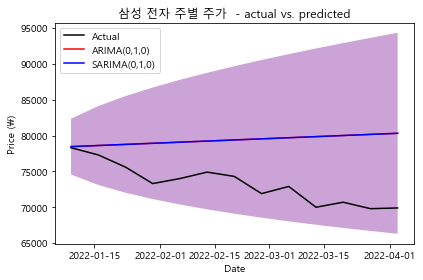

In [23]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=sam_test, color='black', label='Actual')

ax.plot(arima_pred.prediction, c='red', label='ARIMA(0,1,0)')
ax.fill_between(arima_pred.index,arima_pred.ci_lower,arima_pred.ci_upper,alpha=0.2, facecolor='red')

ax.plot(auto_arima_pred.prediction, c='blue', label='SARIMA(0,1,0)')
ax.fill_between(auto_arima_pred.index,auto_arima_pred.ci_lower,auto_arima_pred.ci_upper,alpha=0.2, facecolor='blue')

ax.set(title="삼성 전자 주별 주가  - actual vs. predicted", xlabel='Date', ylabel='Price (\)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

ARIMA 함수와 AUTO-ARIMA 함수의 결과가 같게 나와서 그래프가 겹쳐 보인다. 색칠된 영역은 95% 신뢰구간의 영역이다.